# **ELEC-E5431 – Large-Scale Data Analysis (LSD Analysis)**
**Home Work 2**<br>
**Osman Manzoor Ahmed**<br>
**721347**<br>



In every algorithm the output is as following:
1. Convergance plot according to the difference between the norm value of the function w.r.t the optimal value of X and algo computed value to X
2. In the last convergance plot of all the three algos.


In [38]:
# All Libraries

import pandas as pd 
from matplotlib import pyplot as plt 
from IPython.display import display, HTML
import numpy as np  
from scipy import random, linalg
from sklearn.datasets import make_spd_matrix
import math
from random import randint
from scipy.linalg import qr
from scipy.stats import ortho_group



In [39]:
#Matrix A of size 12*100

A = np.random.randn(20, 100)

#matrix x that is sparse with 3 non zero values
x_opt = np.zeros((100,1))
x_opt[8] = 0.88
x_opt[55] = 5.5
x_opt[74] = 1.7


# Creation of Matrix b
b = np.dot(A,x_opt)

# random value of ta (used in Proximal Gradient)
ta = 10
# random value of P (used in ADMM)
P  = 0.1

# value of Alpha

#alpha = 1.0 / np.linalg.norm(np.dot(A.T,A), 2)
Aprod = np.dot(A.T,A)
alpha = 1.0/ Aprod.trace()
#alpha = 1.0/ A.trace()


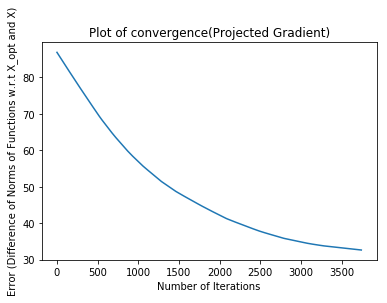

Text(0.5,1,'X Created by Projected Gradient')

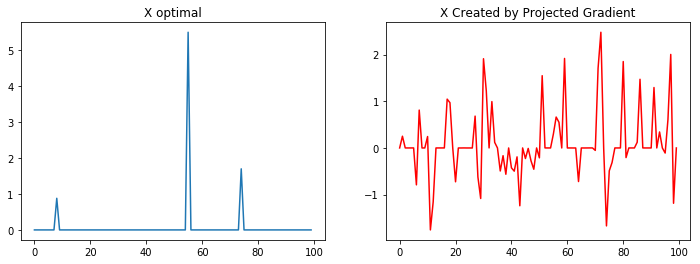

In [51]:
# Projected Subgradient Method for LASSO

# Gradient
def proj_gradient(A,b,x):
    
    Ident = np.identity(A.shape[1])
    Prod = np.dot(np.dot(A.T,np.linalg.inv(np.dot(A,A.T))),A)
    inv = np.subtract(Ident,Prod)
    inver = np.dot(inv,np.sign(x))

    return inver

def sign(xx):
    def proj_elementwise(x):
            if x > 0:
                return 1
            elif x < 0:
                return -1
            else:
                return 0.0
    return np.vectorize(proj_elementwise)(xx)

def calculate_lasso(x):
    x = x.reshape(-1)
    return np.sum(np.abs(x))
    
def projected_Gradient(A,b,alpha,k,ta,norm_xopt):
    n = A.shape[1]
    x = np.random.normal(0, 1, (n,1))
    #x = np.ones((n,1))
    #x = np.zeros((n,1))
    values_of_Lasso = []
    norm_values = []
    norm_values.append(calculate_lasso(x))
    #for i in range(k):
    while(True):
        grad = proj_gradient(A,b,x)
        x = x - alpha * grad
        norm_x = calculate_lasso(x)
        norm_values.append(norm_x)
        values_of_Lasso.append(norm_x - norm_xopt)
        
        error = abs(norm_values[-1] - norm_values[-2]) 
        if(error <= pow(10,-5)):
           break
    return values_of_Lasso,x


# Running of Projected Gradient
projected_norm_xopt = np.sum(np.abs(x_opt))
projected_error,projected_val_x = projected_Gradient(A,b,alpha,100000,ta,projected_norm_xopt)

plt.plot(projected_error)
plt.xlabel('Number of Iterations')
plt.ylabel('Error (Difference of Norms of Functions w.r.t X_opt and X)')
plt.title('Plot of convergence(Projected Gradient)')
plt.show()

fig, axes = plt.subplots(1, 2,figsize=(12, 4))
axes[0].plot(x_opt)
axes[0].set_title("X optimal")
axes[1].plot(projected_val_x,color="red")
axes[1].set_title("X Created by Projected Gradient")
        


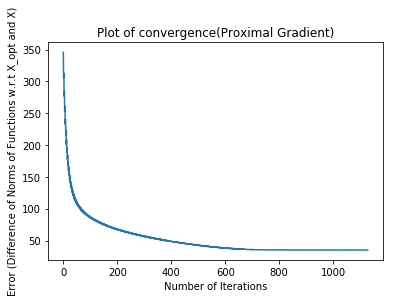

Text(0.5,1,'X Created by Proximal Gradient')

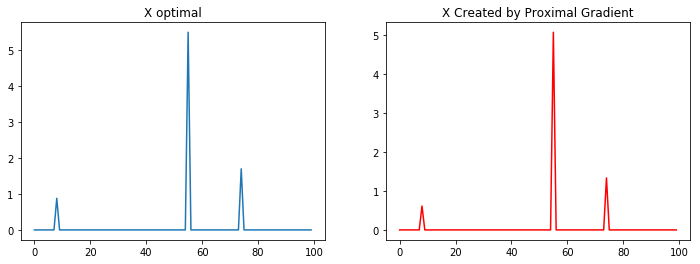

In [57]:
# Proximal Gradient Algorithm for Lasso

# Gradient  A.T(AX-b)
def prox_gradient(A,b,x):
    gradient = np.dot(np.transpose(A),np.subtract(np.dot(A,x),b))
    return gradient

def soft(y,ta):
    def prox_elementwise(y, t):
            if y > t:
                return y - t
            elif y < -t:
                return t - y
            else:
                return 0.0
    return np.vectorize(prox_elementwise)(y, ta)

def calculate_lasso(A,b,x,ta):
    grad = np.subtract(np.dot(A,x),b)
    norm_of_grad = ((np.linalg.norm(grad)) ** 2)*0.5
    x_l1_norm = np.linalg.norm(x, ord=1) * ta
    return norm_of_grad + x_l1_norm
    
def proximal_Gradient(A,b,alpha,k,ta,norm_xopt):
    n = A.shape[1]
    #x = np.random.normal(0, 1, (n,1))
    x = np.zeros((n,1))
    values_of_Lasso = []
    norm_values = []
    norm_values.append(calculate_lasso(A,b,x,ta))
    #for i in range(k):
    while(True):
        grad = prox_gradient(A,b,x)
        x = soft(x - (alpha * grad),alpha * ta)
        norm_x = calculate_lasso(A,b,x,ta)
        norm_values.append(norm_x)
        values_of_Lasso.append(norm_x - norm_xopt)
        
        error = abs(norm_values[-1] - norm_values[-2]) 
        if(error <= pow(10,-5)):
           break 
        
    return values_of_Lasso,x


# Running of Proximal Gradient
proximal_norm_xopt = np.sum(np.square(np.dot(A, x_opt) - b)) + ta * np.sum(np.abs(x_opt)) * 0.5
proximal_error,proximal_val_x = proximal_Gradient(A,b,alpha,100000,ta,proximal_norm_xopt)

plt.plot(proximal_error)
plt.xlabel('Number of Iterations')
plt.ylabel('Error (Difference of Norms of Functions w.r.t X_opt and X)')
plt.title('Plot of convergence(Proximal Gradient)')
plt.show()


fig, axes = plt.subplots(1, 2,figsize=(12, 4))
axes[0].plot(x_opt)
axes[0].set_title("X optimal")
axes[1].plot(proximal_val_x,color="red")
axes[1].set_title("X Created by Proximal Gradient")
                
        
        

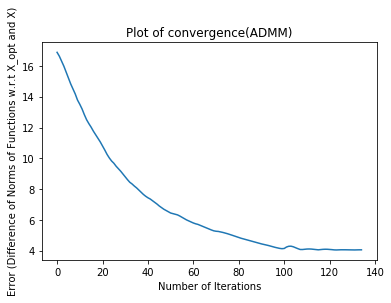

Text(0.5,1,'X Created by ADMM')

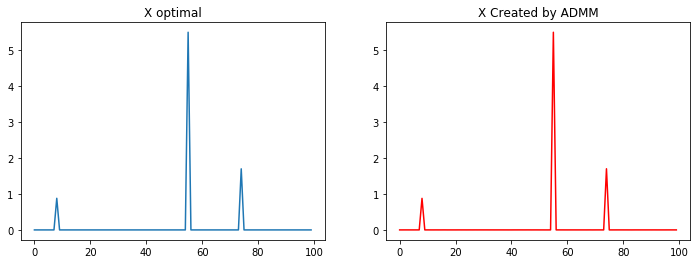

In [53]:
# ADMM Algorithm for Lasso

# Gradient
def ADMM_gradient(A,b,z,y,P):
    
    Ident = np.identity(A.shape[1])
    part_a = np.add(np.dot(A.T,A),P * Ident)
    part_b = np.subtract(np.add(np.dot(A.T,b),P * z),y)
    
    final_part = np.dot(np.linalg.inv(part_a),part_b)
    
    return final_part 

def soft_admm(y,ta):
    def admm_elementwise(y, t):
            if y >= t:
                return y - t
            elif y <= -t:
                return t + y
            else:
                return 0.0
    return np.vectorize(admm_elementwise)(y, ta)

def calculate_lasso(A,b,x,ta):
    grad = np.subtract(np.dot(A,x),b)
    norm_of_grad = ((np.linalg.norm(grad)) ** 2)*0.5
    x_l1_norm = np.linalg.norm(x, ord=1) 
    return norm_of_grad + x_l1_norm
    
def admm_lasso(A,b,alpha,k,P,norm_xopt):
    n = A.shape[1]
    #x = np.random.normal(0, 1, (n,1))
    #x = np.ones((n,1))
    x = np.zeros((n,1))
    z = np.zeros((n,1))
    u = np.zeros((n,1))
    values_of_Lasso = []
    #x = np.dot(np.dot(A.T,np.linalg.inv(np.dot(A,A.T))),b)
    norm_values = []
    norm_values.append(calculate_lasso(A,b,x,ta))
    #for i in range(k):
    while(True):
        grad = ADMM_gradient(A,b,z,u,P)
        x = grad
        z = soft_admm(np.add(x,u),alpha/P)
        u = np.add(u,np.subtract(x,z) * P)
        
        norm_x = calculate_lasso(A,b,x,ta)
        norm_values.append(norm_x)
        values_of_Lasso.append(norm_x - norm_xopt)
        
        error = abs(norm_values[-1] - norm_values[-2]) 
        if(error <= pow(10,-5)):
           break 
    return values_of_Lasso,x


# Running of Proximal Gradient
admm_norm_xopt = np.sum(np.square(np.dot(A, x_opt) - b)) +  np.sum(np.abs(x_opt)) * 0.5
admm_error,admm_val_x = admm_lasso(A,b,alpha,10000,P,admm_norm_xopt)

plt.plot(admm_error)
plt.xlabel('Number of Iterations')
plt.ylabel('Error (Difference of Norms of Functions w.r.t X_opt and X)')
plt.title('Plot of convergence(ADMM)')
plt.show()


fig, axes = plt.subplots(1, 2,figsize=(12, 4))
axes[0].plot(x_opt)
axes[0].set_title("X optimal")
axes[1].plot(admm_val_x,color="red")
axes[1].set_title("X Created by ADMM")
        

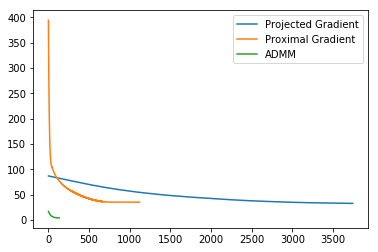

In [54]:
# Convergance Plot of all 

plt.plot(projected_error)
plt.plot(proximal_error)
plt.plot(admm_error)

plt.legend(['Projected Gradient', 'Proximal Gradient', 'ADMM'], loc='upper right')

plt.show()